### Data Mining Project (CS 6220): Don't Get Kicked

* Wendi Luo (Email: luo.wen@husky.neu.edu)
* Seyedeh Negin Mortazavi (Email: mortazavi.s@husky.neu.edu)      
Graduate Students          
Department of Computer Science   
Northeastern University, San Jose, CA

In [1]:
#load libraries
%matplotlib inline 
import numpy as np 
import scipy as sp 
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import pandas as pd 

#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# prevent warning messages
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Reading data and show 5 first rows of data to get some sense how data looks like
df = pd.read_csv("/Users/luowendi/Documents/training.csv")
df.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1.0,Alloy,89046,OTHER ASIAN,MEDIUM,OTHER,8155.0,9829.0,11636.0,13600.0,7451.0,8552.0,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1.0,Alloy,93593,AMERICAN,LARGE TRUCK,CHRYSLER,6854.0,8383.0,10897.0,12572.0,7456.0,9222.0,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2.0,Covers,73807,AMERICAN,MEDIUM,CHRYSLER,3202.0,4760.0,6943.0,8457.0,4035.0,5557.0,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,1.0,Alloy,65617,AMERICAN,COMPACT,CHRYSLER,1893.0,2675.0,4658.0,5690.0,1844.0,2646.0,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,2.0,Covers,69367,AMERICAN,COMPACT,FORD,3913.0,5054.0,7723.0,8707.0,3247.0,4384.0,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


In [6]:
#Defining data shape and data type for each feature (column)
print('Shape of data frame is: (%i,%i) \n' % df.shape)
print('Types of columns in data frame is:')
df.dtypes

Shape of data frame is: (72983,34) 

Types of columns in data frame is:


RefId                                  int64
IsBadBuy                               int64
PurchDate                             object
Auction                               object
VehYear                                int64
VehicleAge                             int64
Make                                  object
Model                                 object
Trim                                  object
SubModel                              object
Color                                 object
Transmission                          object
WheelTypeID                          float64
WheelType                             object
VehOdo                                 int64
Nationality                           object
Size                                  object
TopThreeAmericanName                  object
MMRAcquisitionAuctionAveragePrice    float64
MMRAcquisitionAuctionCleanPrice      float64
MMRAcquisitionRetailAveragePrice     float64
MMRAcquisitonRetailCleanPrice        float64
MMRCurrent

# **Feature Engineering**

In [7]:
# see how the NaN/Missing value is spread over columns of data frame
missing_values_count_per_column = np.sum(df.isnull(),axis=0)
missing_values_percentage_per_column = 100.0 * (missing_values_count_per_column) / len(df)
print(missing_values_percentage_per_column)

RefId                                 0.000000
IsBadBuy                              0.000000
PurchDate                             0.000000
Auction                               0.000000
VehYear                               0.000000
VehicleAge                            0.000000
Make                                  0.000000
Model                                 0.000000
Trim                                  3.233630
SubModel                              0.010961
Color                                 0.010961
Transmission                          0.012332
WheelTypeID                           4.342107
WheelType                             4.348958
VehOdo                                0.000000
Nationality                           0.006851
Size                                  0.006851
TopThreeAmericanName                  0.006851
MMRAcquisitionAuctionAveragePrice     0.024663
MMRAcquisitionAuctionCleanPrice       0.024663
MMRAcquisitionRetailAveragePrice      0.024663
MMRAcquisiton

In [8]:

# Column removal from feature set:
# 1- columns "PRIMEUNIT" and "AUCGUART" have 95% missing data, ignore these columns
# 2- "RefID" is a unique ID assigned to each car and so does not have useful information for classification, so we can ignore that columns as well
# 3- "PurchDate" ~= "VehYear" + "VehicleAge", so we remove "PurchDate" column as well
df_prunned = df.copy()
df_prunned = df_prunned.drop(['RefId','PurchDate','PRIMEUNIT','AUCGUART'],axis=1)

In [9]:
# Now we need to see which feature column has numerical value
# and which one has non-numerical value to be able to impute missing values
numeric_column = []
non_numeric_column = []
for col in df_prunned.columns:
    if df_prunned[col].dtype == object:
        non_numeric_column.append(col)
    else:
        numeric_column.append(col)
print("Numeric columns are: %s\n"%numeric_column)
print("Non-Numeric columns are: %s\n"%non_numeric_column)

Numeric columns are: ['IsBadBuy', 'VehYear', 'VehicleAge', 'WheelTypeID', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'BYRNO', 'VNZIP1', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']

Non-Numeric columns are: ['Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName', 'VNST']



In [10]:
# First let's take care of non_numeric_column
# We remove samples from data frame which has at least one missing data in non numeric column (The first less time consuming
# approach to get rid of non-numeric missing data 
df_prunned_non_numeric_no_null = df_prunned.copy()
for col in non_numeric_column:
    df_prunned_non_numeric_no_null.dropna(subset=[col], how='any',inplace=True)

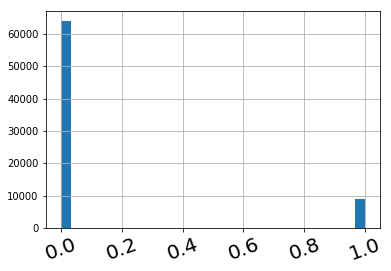

In [11]:
# Now let's check how to remove data samples which have at least one non-numeric columns with missing data affects whole data size
# First,before removing samples which include null in non-numeric columns
df_prunned.IsBadBuy.hist(bins=30,grid=True,xlabelsize=20,xrot=20);

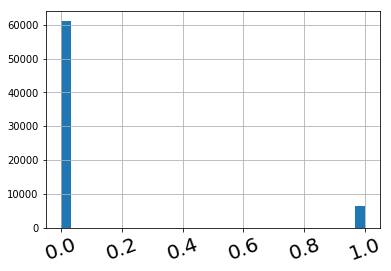

In [12]:
# After removing samples, it include null in non-numeric columns
df_prunned_non_numeric_no_null.IsBadBuy.hist(bins=30,grid=True,xlabelsize=20,xrot=20);

In [13]:
# It seems there's only a little loss. Now we should take care of existing missing data in df_prunned_non_numeric_no_null
df_columns = df_prunned_non_numeric_no_null.columns
data = df_prunned_non_numeric_no_null.as_matrix()
df_prunned_non_numeric_no_null.head()

target_col = []
from sklearn.preprocessing import Imputer
for i, col in enumerate(df_columns):
    if col in numeric_column:
        target_col.append(i)  
imputer_numeric = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputer_numeric.fit(data[:,target_col])
data[:,target_col] = imputer_numeric.transform(data[:,target_col])

# df_prunned_no_null is a datframe of object without missing data
df_prunned_no_null = pd.DataFrame(data,columns=df_columns)

In [14]:
# Let's see how the NaN/missing value is spread over columns of dataframe (It should not be any missing value!)
missing_values_count_per_column = np.sum(df_prunned_no_null.isnull(),axis=0)
missing_values_percentage_per_column = 100.0 * (missing_values_count_per_column) / len(df_prunned_no_null)
print(missing_values_percentage_per_column)

IsBadBuy                             0.0
Auction                              0.0
VehYear                              0.0
VehicleAge                           0.0
Make                                 0.0
Model                                0.0
Trim                                 0.0
SubModel                             0.0
Color                                0.0
Transmission                         0.0
WheelTypeID                          0.0
WheelType                            0.0
VehOdo                               0.0
Nationality                          0.0
Size                                 0.0
TopThreeAmericanName                 0.0
MMRAcquisitionAuctionAveragePrice    0.0
MMRAcquisitionAuctionCleanPrice      0.0
MMRAcquisitionRetailAveragePrice     0.0
MMRAcquisitonRetailCleanPrice        0.0
MMRCurrentAuctionAveragePrice        0.0
MMRCurrentAuctionCleanPrice          0.0
MMRCurrentRetailAveragePrice         0.0
MMRCurrentRetailCleanPrice           0.0
BYRNO           

# **Data Exploration**

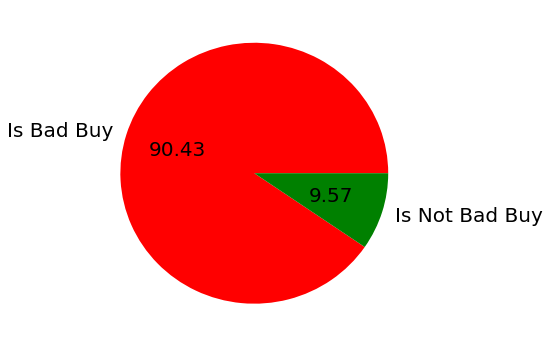

In [15]:
# First, let's see how different classes are spread over data set
series = pd.Series(df_prunned_no_null.IsBadBuy.value_counts(), index=['0', '1'], name='')
series.plot.pie(figsize=(6, 6),autopct='%.2f', fontsize=20,labels=['Is Bad Buy', 'Is Not Bad Buy'], colors=['r', 'g'])

In [16]:
# Now let's see data features are spread over different class
# This function take the data frame and target column and plot stacked bar graph for target features based on class label
def make_stack_bar(df, column, x_label=None, y_label=None, title=None):
    plt.rcParams['figure.figsize']=(14,5);
    set0 = set(df_prunned_no_null[column][( df_prunned_no_null.IsBadBuy == 0)])
    set1 = set(df_prunned_no_null[column][( df_prunned_no_null.IsBadBuy == 1)])
    all_set = set0.union(set1)

    stat = dict()
    stat["Is Good Buy"] = {}
    stat["Is Bad Buy"] = {}
    for kind in all_set:
        stat["Is Good Buy"][kind] = 0
        stat["Is Bad Buy"][kind] = 0

    data_1 = df_prunned_no_null[column][( df_prunned_no_null.IsBadBuy == 1)]
    for kind in data_1:
        stat["Is Good Buy"][kind] += 1

    data_0 = df_prunned_no_null[column][( df_prunned_no_null.IsBadBuy == 0)]
    for kind in data_0:
        stat["Is Bad Buy"][kind] += 1


    data = pd.DataFrame.from_dict(stat)
    ax = data.plot(kind='bar',stacked=True, logy=True)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

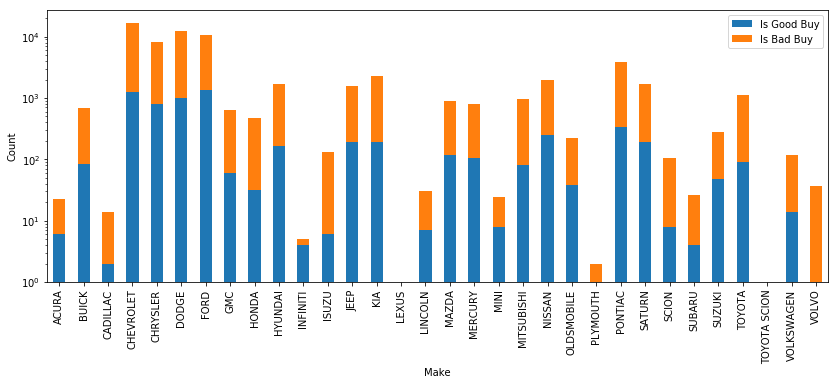

In [17]:
# First let's see how "Make" is distributed over different classes
desired_column = "Make"
make_stack_bar(df_prunned_no_null, column=desired_column, x_label=desired_column, y_label="Count",title="Stacked count bar graph for \"" + desired_column + "\" vs class label")

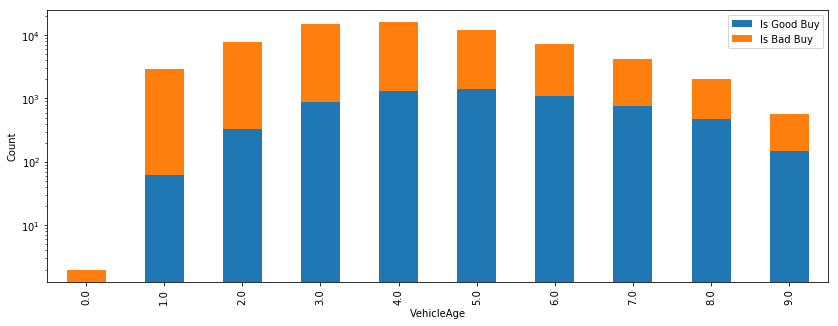

In [18]:
# Now let's see how "VehicleAge" is distributed over diffrent classes
desired_column = "VehicleAge"
make_stack_bar(df_prunned_no_null, column=desired_column,x_label= desired_column, y_label="Count",title="Stacked count bar graph for \"" + desired_column + "\" vs class label")

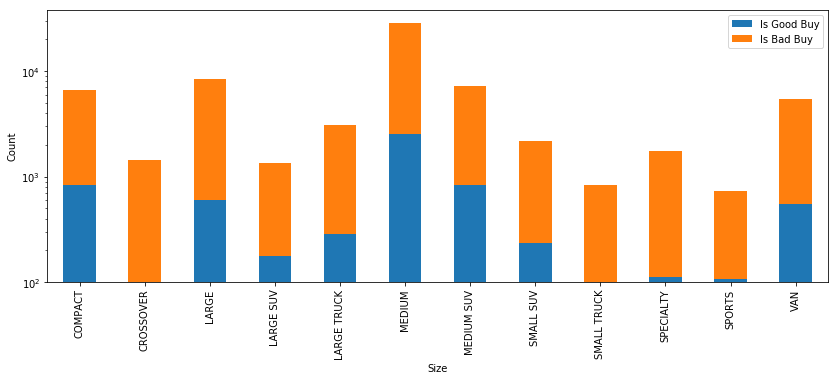

In [19]:
# Now let see how "Size" is distributed over different classes
desired_column = "Size"
make_stack_bar(df_prunned_no_null, column=desired_column,x_label= desired_column, y_label="Count",title="Stacked count bar graph for \"" + desired_column + "\" vs class label")

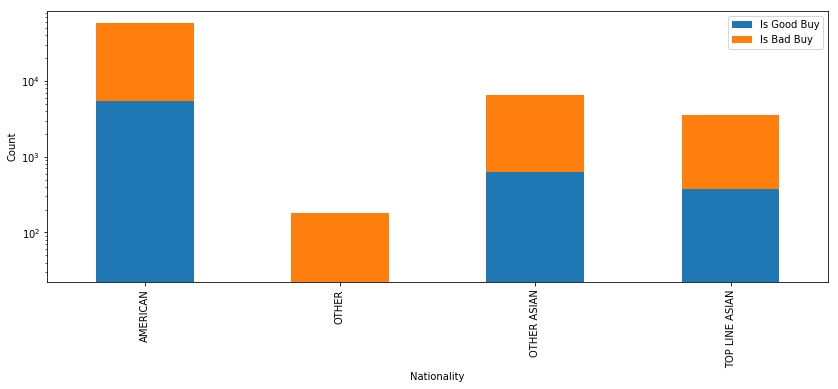

In [20]:
# Now let's see how "Nationality" is distributed over different classes
desired_column = "Nationality"
make_stack_bar(df_prunned_no_null, column=desired_column,x_label= desired_column, y_label="Count",title="Stacked count bar graph for \"" + desired_column + "\" vs class label")

# **Model Training**

In [21]:
# First we need to do LabelEncoding to conver non-numerical cloumns to numerical values to be able to apply classifier
df_prunned_no_null_labelencoder = df_prunned_no_null.copy()
from sklearn.preprocessing import LabelEncoder
for col in df_prunned_no_null_labelencoder.columns:
    le = LabelEncoder()
    if df_prunned_no_null_labelencoder[col].dtype == object:
        df_prunned_no_null_labelencoder[col] = le.fit_transform(df_prunned_no_null_labelencoder[col])

In [22]:
# By now, we have all data converted to numerical value.
# Since we have used LabelEncoder, we should use non-linear classifier. 
# Before setting up classifier, we need to do train-test split.
from sklearn.cross_validation import train_test_split
y = df_prunned_no_null_labelencoder['IsBadBuy']
X = df_prunned_no_null_labelencoder.drop('IsBadBuy',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
# Since data is unbalanced, first we do is to upsampling over training data
from imblearn.over_sampling import SMOTE
smote = SMOTE(ratio='auto', kind='regular')
X_train_upsampled, y_train_upsampled = smote.fit_sample(X_train.as_matrix(), y_train.as_matrix())

In [26]:
print("The ratio of class = 1 to class = 0 is %.2f"%(1.0 * sum(y_train_upsampled == 1)/sum(y_train_upsampled==0)))

The ratio of class = 1 to class = 0 is 1.00


In [30]:

# Ok now data for train is balanced.
# Now lets do training and testing
# We use AdaBoost classifier with Decision Tree as base
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import pickle
## You can make it true to train everything again but takes time
training = False

if training:
    ## Adaboost
    adaboost_args = {'random_state':0}
    parameters = {'n_estimators': [x for x in range(10,101,20)], 
                  'learning_rate': [x for x in np.arange(0.0001,0.0003,0.0001)]}

    clfAdaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, random_state= 0),random_state= 0)
    gs = GridSearchCV(clfAdaboost, param_grid=parameters, cv=3, n_jobs=8, scoring='roc_auc')
    gs.fit(X_train_upsampled, y_train_upsampled)
    best = gs.best_estimator_
    
    # Now train the best classifier on training data 
    best.fit(X_train_upsampled, y_train_upsampled)
    
    ## save the model
    pickle.dump(best,open('/Users/luowendi/Documents/Kaggle-Project-Dont-get-kicked-master/models/best_model.pkl','wb'))
else:
    best = pickle.load(open('/Users/luowendi/Documents/Kaggle-Project-Dont-get-kicked-master/models/best_model.pkl','rb'))

# Predicting the test set results
y_pred = best.predict(X_test)

#accuracy
accuracy_ = accuracy_score(y_pred,y_test.as_matrix())

#f1 score
f1_ = f1_score(y_pred,y_test.as_matrix())

# Area Under Curve (AUC)
roc_ = roc_auc_score(y_pred,y_test.as_matrix())

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Adaboost Classifier with Decision Tree as base: accuracy = %.2f, f1 score = %.2f , roc = %.2f' %(accuracy_,f1_,roc_))

[[9824 2402]
 [ 807  483]]
Adaboost Classifier with Decision Tree as base: accuracy = 0.76, f1 score = 0.23 , roc = 0.55
